In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/processed-data/weather_data.csv
/kaggle/input/weather/testset.csv


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

2024-06-29 09:08:55.972765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 09:08:55.972905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 09:08:56.110423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [4]:
ndls_Temp_org_full=pd.read_csv('/kaggle/input/processed-data/weather_data.csv')

In [5]:
print(ndls_Temp_org_full["wdire"].value_counts())
print("No of unique conditions:",len(ndls_Temp_org_full["wdire"].unique()))

wdire
0      38242
270    24818
90     16290
315     7117
180     5310
135     3513
225     3200
45      2500
Name: count, dtype: int64
No of unique conditions: 8


In [6]:
ndls_Temp_org_full["wdire"]=ndls_Temp_org_full["wdire"].replace(["WNW", "WSW", "ESE", "ENE", "NNW", "SSE", "NNE" ,"SSW", "Variable"], 
                                                                ["West", "West", "East", "East", "North", "South", "North", "South", "North"])

In [7]:
ndls_Temp_org_full["wdire"].value_counts()

wdire
0      38242
270    24818
90     16290
315     7117
180     5310
135     3513
225     3200
45      2500
Name: count, dtype: int64

In [8]:
deg=45
ndls_Temp_org_full["wdire"]=ndls_Temp_org_full["wdire"].replace(["North","NE", "East","SE", "South","SW", "West", "NW"],
                                                                [0, deg, 2*deg, 3*deg, 4*deg, 5*deg, 6*deg, 7*deg])

In [9]:
ndls_Temp_org_full["wdire"].value_counts()

wdire
0      38242
270    24818
90     16290
315     7117
180     5310
135     3513
225     3200
45      2500
Name: count, dtype: int64

In [10]:
ndls_Temp_org_full

,datetimeutc,conds,dewptm,hum,pressurem,tempm,vism,wdird,wdire,wspdm
0,19961101-11:00,7.0,9.0,27.0,1010.0,30.0,5.0,280.0,270,7.4
1,19961101-12:00,7.0,10.0,32.0,-9999.0,28.0,2.0,240.0,0,9.3
2,19961101-13:00,7.0,11.0,44.0,-9999.0,24.0,2.0,240.0,0,9.3
3,19961101-14:00,7.0,10.0,41.0,1010.0,24.0,2.0,240.0,0,9.3
4,19961101-16:00,7.0,11.0,47.0,1011.0,23.0,1.2,240.0,0,9.3
...,...,...,...,...,...,...,...,...,...,...
100985,20170424-06:00,4.0,17.0,25.0,1005.0,34.0,4.0,320.0,315,11.1
100986,20170424-09:00,4.0,14.0,16.0,1003.0,38.0,4.0,320.0,315,22.2
100987,20170424-12:00,4.0,12.0,14.0,1002.0,36.0,4.0,270.0,270,18.5
100988,20170424-15:00,4.0,15.0,27.0,1004.0,32.0,2.0,320.0,315,3.7


In [11]:
timeseries_fulldata=ndls_Temp_org_full.copy()

In [12]:
timeseries_fulldata["datetimeutc"].dtype

dtype('O')

In [13]:
timeseries_fulldata["datetimeutc"]=pd.to_datetime(timeseries_fulldata["datetimeutc"])

In [14]:
timeseries_fulldata.set_index("datetimeutc", inplace=True)

In [15]:
timeseries_fulldata

,conds,dewptm,hum,pressurem,tempm,vism,wdird,wdire,wspdm
datetimeutc,,,,,,,,,
1996-11-01 11:00:00,7.0,9.0,27.0,1010.0,30.0,5.0,280.0,270,7.4
1996-11-01 12:00:00,7.0,10.0,32.0,-9999.0,28.0,2.0,240.0,0,9.3
1996-11-01 13:00:00,7.0,11.0,44.0,-9999.0,24.0,2.0,240.0,0,9.3
1996-11-01 14:00:00,7.0,10.0,41.0,1010.0,24.0,2.0,240.0,0,9.3
1996-11-01 16:00:00,7.0,11.0,47.0,1011.0,23.0,1.2,240.0,0,9.3
...,...,...,...,...,...,...,...,...,...
2017-04-24 06:00:00,4.0,17.0,25.0,1005.0,34.0,4.0,320.0,315,11.1
2017-04-24 09:00:00,4.0,14.0,16.0,1003.0,38.0,4.0,320.0,315,22.2
2017-04-24 12:00:00,4.0,12.0,14.0,1002.0,36.0,4.0,270.0,270,18.5


In [16]:
ndls_daily=timeseries_fulldata.resample("D").mean()

In [17]:
ndls_daily

,conds,dewptm,hum,pressurem,tempm,vism,wdird,wdire,wspdm
datetimeutc,,,,,,,,,
1996-11-01,7.000,11.666667,52.916667,-2659.666667,22.333333,2.083333,243.333333,22.500000,9.141667
1996-11-02,6.375,10.458333,48.625000,1009.833333,22.916667,3.291667,236.666667,108.750000,12.062500
1996-11-03,7.000,12.041667,55.958333,1010.500000,21.791667,2.262500,246.666667,108.750000,9.829167
1996-11-04,6.500,10.222222,48.055556,1011.333333,22.722222,2.272222,242.222222,52.500000,9.088889
1996-11-05,7.000,8.200000,29.400000,1011.800000,27.800000,3.900000,208.000000,207.000000,10.020000
...,...,...,...,...,...,...,...,...,...
2017-04-20,4.000,16.750000,27.500000,998.625000,34.500000,2.500000,222.500000,157.500000,7.887500
2017-04-21,4.000,21.500000,39.375000,999.875000,34.250000,2.000000,92.500000,84.375000,6.962500
2017-04-22,4.300,20.400000,40.900000,1001.600000,32.900000,1.950000,163.000000,90.000000,10.750000


In [18]:
ndls_daily.isnull().sum()

conds        141
dewptm       141
hum          141
pressurem    141
tempm        141
vism         141
wdird        141
wdire        141
wspdm        141
dtype: int64

In [19]:
ndls_daily.fillna(ndls_daily.mean(), inplace=True)

In [20]:
ndls_daily.isnull().sum()

conds        0
dewptm       0
hum          0
pressurem    0
tempm        0
vism         0
wdird        0
wdire        0
wspdm        0
dtype: int64

In [21]:
ndls_daily_temp=pd.DataFrame(list(ndls_daily['tempm']), columns=['temp'])
ndls_daily_temp

,temp
0,22.333333
1,22.916667
2,21.791667
3,22.722222
4,27.800000
...,...
7475,34.500000
7476,34.250000
7477,32.900000
7478,32.875000


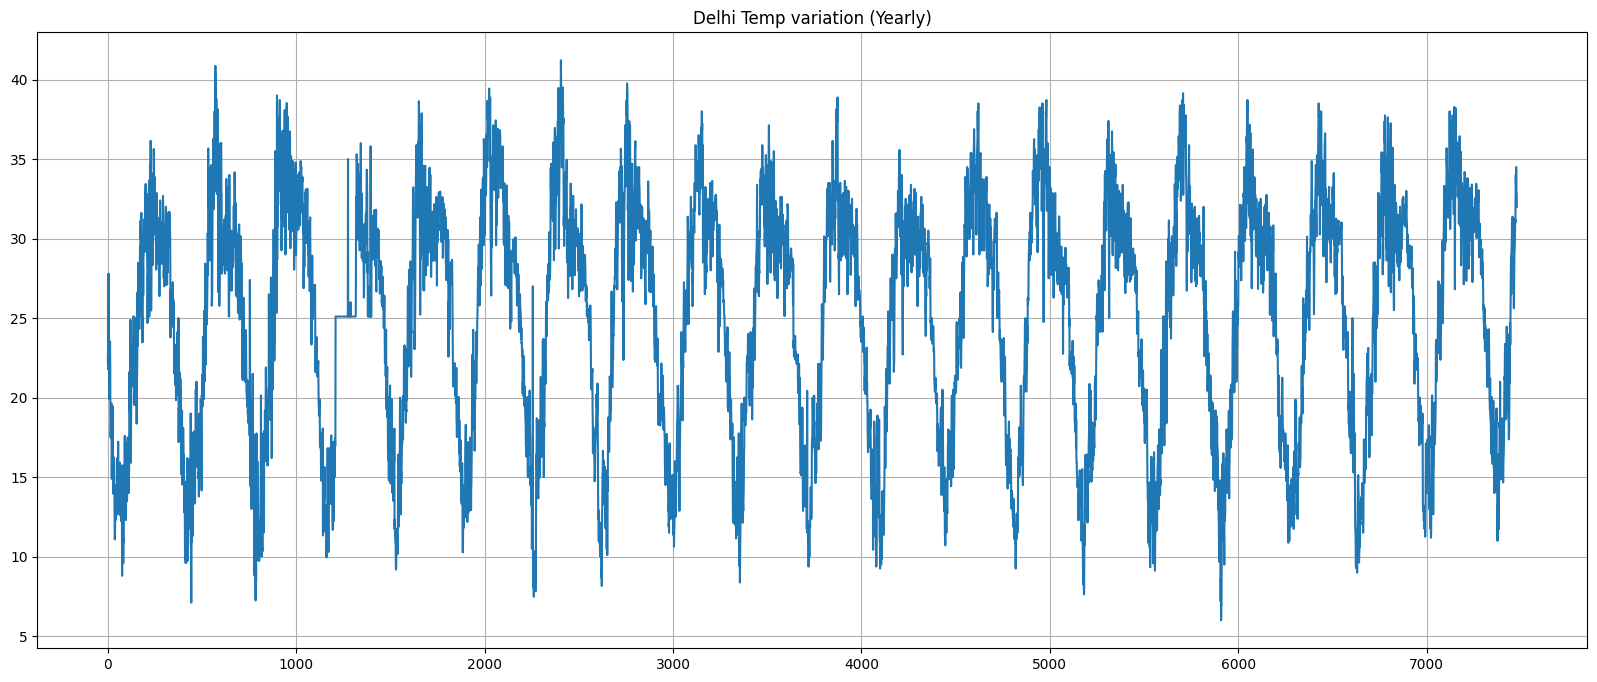

In [22]:
plt.figure(figsize=(20,8))
plt.plot(ndls_daily_temp)
plt.grid()
plt.title("Delhi Temp variation (Yearly)") 
plt.show()

In [23]:
scaler=MinMaxScaler(feature_range=(-1,1))
ndls_daily_temp_scaled=scaler.fit_transform(ndls_daily_temp)

In [24]:
print(ndls_daily_temp_scaled)
print(ndls_daily_temp_scaled.shape)

[[-0.07224714]
 [-0.0391131 ]
 [-0.10301445]
 ...
 [ 0.52795217]
 [ 0.52653214]
 [ 0.47683109]]
(7480, 1)


In [25]:
steps=30
X_part=[]
Y_part=[]
for i in range(len(ndls_daily_temp_scaled)-(steps)):
    X_part.append(ndls_daily_temp_scaled[i:i+steps])
    Y_part.append(ndls_daily_temp_scaled[i+steps])
    
X_part=np.array(X_part)
Y_part=np.array(Y_part)

print(X_part.shape)
print(Y_part.shape)

(7450, 30, 1)
(7450, 1)


In [26]:
train_X=X_part[:7300,::]
test_X=X_part[7300:,::]
print("train_X Shape:",train_X.shape, ",test_X Shape:", test_X.shape)

train_Y=Y_part[:7300]
test_Y=Y_part[7300:]
print("test_Y Shape:",train_Y.shape, ",test_Y Shape:", test_Y.shape)

train_X Shape: (7300, 30, 1) ,test_X Shape: (150, 30, 1)
test_Y Shape: (7300, 1) ,test_Y Shape: (150, 1)


In [45]:
from keras import layers, models

model1 = models.Sequential()

model1.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(30,1)))
model1.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model1.add(layers.Dropout(0.1))  # Dropout after the middle convolutional layer
model1.add(layers.MaxPooling1D(pool_size=2))
model1.add(layers.Conv1D(filters=256, kernel_size=2, activation="relu"))
model1.add(layers.Flatten())
model1.add(layers.RepeatVector(30))  # same as input (30,1)

# Using LSTM with recurrent dropout
model1.add(layers.LSTM(units=100, return_sequences=True, activation="relu", recurrent_dropout=0.2))
model1.add(layers.LSTM(units=100, return_sequences=True, activation="relu", recurrent_dropout=0.2))
model1.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu", recurrent_dropout=0.2)))

model1.add(layers.Dense(100, activation="relu"))
model1.add(layers.Dense(1))


In [46]:
from tensorflow.keras import optimizers

# Compile the model with the corrected argument
model1.compile(loss="mae", optimizer=optimizers.Adam(learning_rate=0.0001))


In [47]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 29, 128)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 28, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 13, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3328)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 30, 3328)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 100)        │     1,371,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,811,369 (6.91 MB)

 Trainable params: 1,811,369 (6.91 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
Earlystp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5, restore_best_weights=True)
Savemod = callbacks.ModelCheckpoint(filepath="model1_ts.keras", monitor="loss", save_best_only=True)


In [50]:
history = model1.fit(train_X, train_Y, epochs=200, verbose=1, callbacks=[Earlystp, Savemod])


Epoch 1/200
  5/229 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.3817

W0000 00:00:1719653234.472947     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


229/229 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - loss: 0.2081
Epoch 2/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1001
Epoch 3/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0865
Epoch 4/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0803
Epoch 5/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0790
Epoch 6/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0775
Epoch 7/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0774
Epoch 8/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0755
Epoch 9/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0760
Epoch 10/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0739
Epoch 11/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0738
Epoch 12/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0740
Epoch 13/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0733
Epoch 14/200
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0735
Epoch 15/200
229/229 ━━━━━━━━━━━━━━━━━━━

In [51]:
hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)

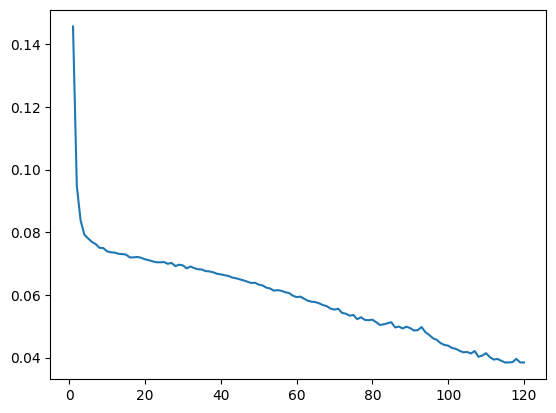

In [52]:
plt.plot(epoch, train_loss)

In [53]:
model1_pt=models.load_model("model1_ts.keras")

In [54]:
ts_temp=model1_pt.predict(test_X)

1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step

W0000 00:00:1719653904.183738     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step


In [55]:
ts_temp=scaler.inverse_transform(ts_temp)

In [56]:
test_Y_inv=scaler.inverse_transform(test_Y)

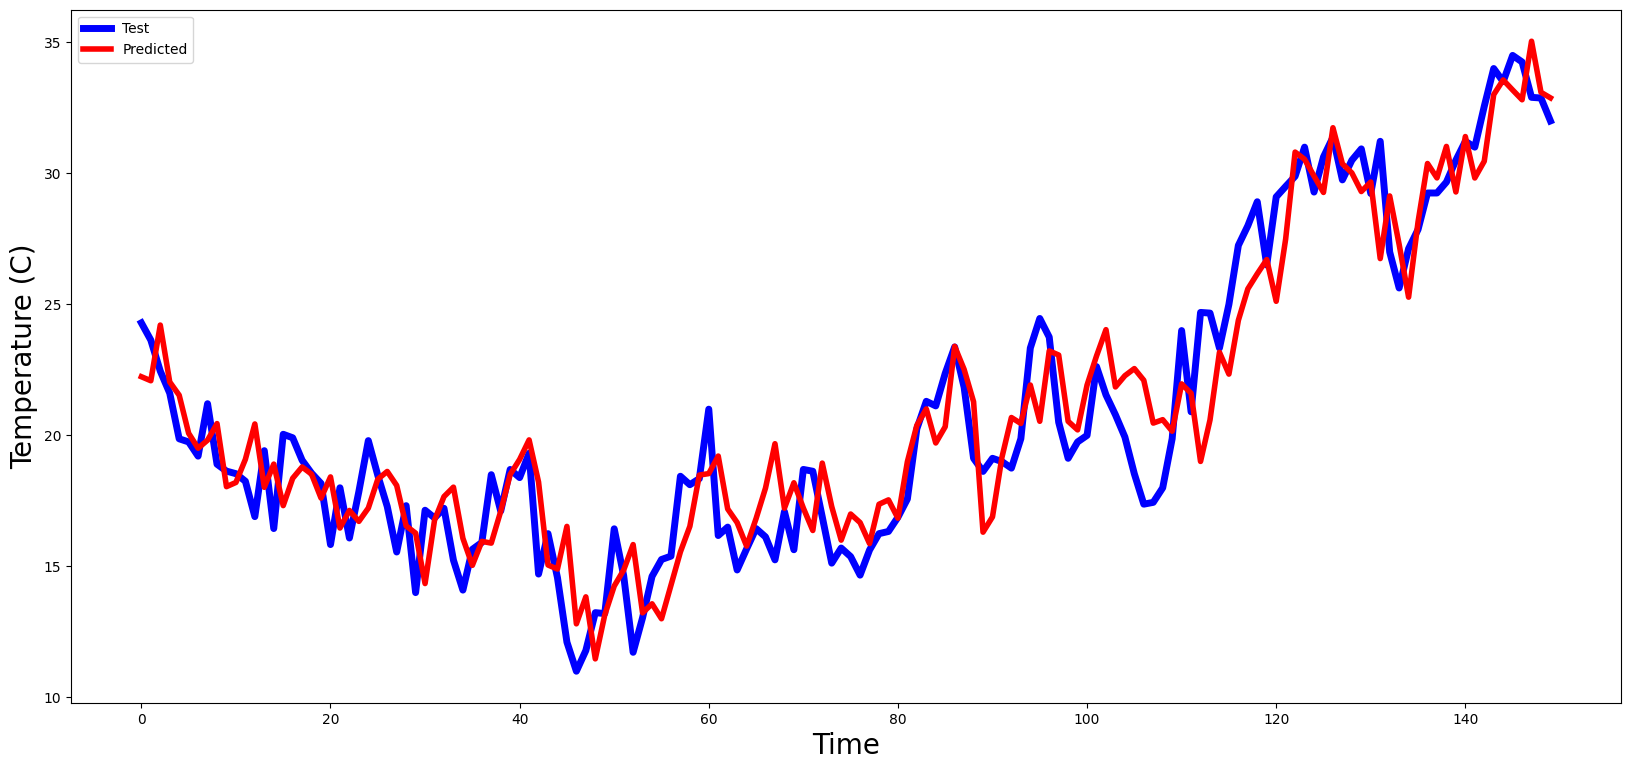

In [57]:
plt.figure(figsize=(20,9))
plt.plot(test_Y_inv , 'blue', linewidth=5)
plt.plot(ts_temp,'r' , linewidth=4)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Temperature (C)", fontsize=20)
plt.legend(('Test','Predicted'))
plt.show()

In [58]:
mse=mean_squared_error(test_Y_inv, ts_temp)
mae=mean_absolute_error(test_Y_inv, ts_temp)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

Mean Squared Error: 3.690148870501615 and Mean Absolute Error: 1.5132502833969774


In [59]:
X_part=ndls_daily.drop(["tempm"], axis=1)
Y_part=ndls_daily["tempm"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)

.### trainR_X=input[:7300,::]
testR_X=input[7300:,::]
print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)

trainR_Y=output[:7300]
testR_Y=output[7300:]
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)